In [2]:
# Import libraries for data handling, image processing, machine learning, and plotting
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


In [3]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Define the path to the dataset folder
base_path = '/content/drive/MyDrive/CVPR/animals_dataset/'

# Read the subfolder names as categories
class_names = os.listdir(base_path)

# Confirm that there are exactly 3 categories
print("Detected categories:", class_names)
if len(class_names) != 3:
    raise Exception("Dataset must contain exactly 3 categories.")


Detected categories: ['cats', 'dogs', 'panda']


In [5]:
# This function reads, resizes, and converts images for each category
def get_images_and_labels(path, classes, limit_per_class=100):
    data = []
    targets = []

    for label in classes:
        folder = os.path.join(path, label)
        files = os.listdir(folder)[:limit_per_class]  # Load only up to 100 images

        for img_name in tqdm(files, desc=f"Reading {label}"):
            full_path = os.path.join(folder, img_name)
            try:
                img = cv2.imread(full_path)                    # Load image
                img = cv2.resize(img, (64, 64))                # Resize to 64x64
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # Convert BGR to RGB
                data.append(img)
                targets.append(label)
            except Exception as err:
                print(f"Could not load {full_path}: {err}")

    return np.array(data), np.array(targets)


In [6]:
# Load all images and corresponding category labels
X_images, y_labels = get_images_and_labels(base_path, class_names)


Reading panda: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


In [7]:
# Print the number of images found for each class
print("\nImage count by category:")
for name in class_names:
    print(f"{name}: {np.sum(y_labels == name)}")



Image count by category:
cats: 100
dogs: 100
panda: 100


In [8]:
# Flatten 64x64x3 image to 1D vector and normalize pixel values to [0, 1]
X_flattened = X_images.reshape(X_images.shape[0], -1) / 255.0

# Encode string labels into integers
y_encoded = LabelEncoder().fit_transform(y_labels)


In [9]:
# Create 5-fold cross-validation object
splits = 5
folds = KFold(n_splits=splits, shuffle=True, random_state=42)

# Set range of k values to test (1 to 20)
k_range = range(1, 21)
avg_scores = []  # To store mean accuracy for each k


In [10]:
# Loop over each k value and evaluate using K-Fold
for neighbors in k_range:
    print(f"\nEvaluating for k = {neighbors}")
    fold_scores = []

    for fold_idx, (train_ids, test_ids) in enumerate(folds.split(X_flattened)):
        # Split data for this fold
        X_train, X_test = X_flattened[train_ids], X_flattened[test_ids]
        y_train, y_test = y_encoded[train_ids], y_encoded[test_ids]

        # Initialize and train KNN model
        model = KNeighborsClassifier(n_neighbors=neighbors, metric='euclidean')
        model.fit(X_train, y_train)

        # Predict and compute accuracy
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        fold_scores.append(acc)

    # Store average accuracy for this value of k
    mean_score = np.mean(fold_scores)
    avg_scores.append(mean_score)
    print(f"Average accuracy for k={neighbors}: {mean_score:.4f}")



Evaluating for k = 1
Average accuracy for k=1: 0.4367

Evaluating for k = 2
Average accuracy for k=2: 0.3967

Evaluating for k = 3
Average accuracy for k=3: 0.3800

Evaluating for k = 4
Average accuracy for k=4: 0.3867

Evaluating for k = 5
Average accuracy for k=5: 0.3867

Evaluating for k = 6
Average accuracy for k=6: 0.3900

Evaluating for k = 7
Average accuracy for k=7: 0.3967

Evaluating for k = 8
Average accuracy for k=8: 0.4067

Evaluating for k = 9
Average accuracy for k=9: 0.4100

Evaluating for k = 10
Average accuracy for k=10: 0.4000

Evaluating for k = 11
Average accuracy for k=11: 0.3867

Evaluating for k = 12
Average accuracy for k=12: 0.4000

Evaluating for k = 13
Average accuracy for k=13: 0.3833

Evaluating for k = 14
Average accuracy for k=14: 0.3900

Evaluating for k = 15
Average accuracy for k=15: 0.3900

Evaluating for k = 16
Average accuracy for k=16: 0.3833

Evaluating for k = 17
Average accuracy for k=17: 0.4133

Evaluating for k = 18
Average accuracy for k=18:

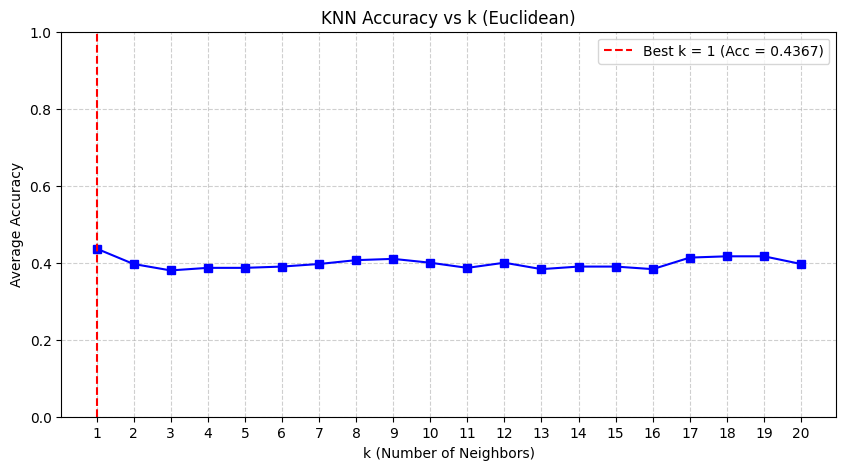

In [11]:
# Plot average accuracy for each k value
plt.figure(figsize=(10, 5))
plt.plot(k_range, avg_scores, marker='s', color='blue')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Average Accuracy")
plt.title("KNN Accuracy vs k (Euclidean)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_range)
plt.ylim(0, 1)

# Highlight the best-performing k value
optimal_k = k_range[np.argmax(avg_scores)]
optimal_acc = max(avg_scores)
plt.axvline(x=optimal_k, linestyle='--', color='red', label=f'Best k = {optimal_k} (Acc = {optimal_acc:.4f})')
plt.legend()
plt.show()


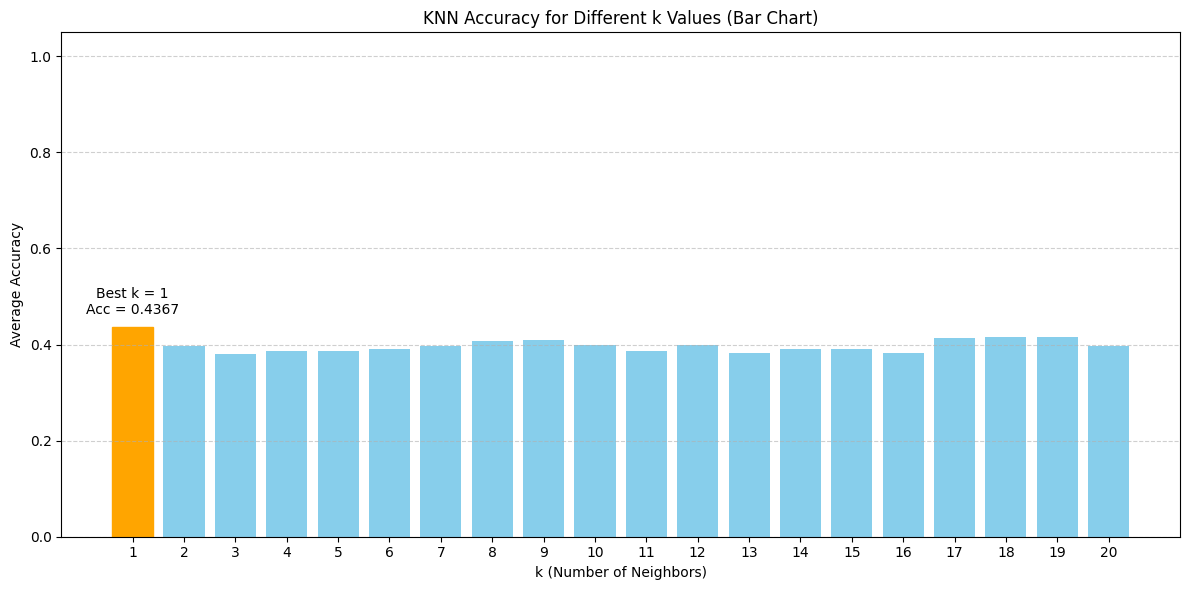

In [13]:
# Plot bar chart of average accuracy for each k
plt.figure(figsize=(12, 6))
bars = plt.bar(k_range, avg_scores, color='skyblue')

# Highlight the bar corresponding to the best k value
best_k_index = np.argmax(avg_scores)
bars[best_k_index].set_color('orange')

# Annotate the best accuracy on top of the bar
plt.text(best_k_index + 1, avg_scores[best_k_index] + 0.02,
         f'Best k = {k_range[best_k_index]}\nAcc = {avg_scores[best_k_index]:.4f}',
         ha='center', va='bottom', fontsize=10, color='black')

# Set labels and title
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Average Accuracy")
plt.title("KNN Accuracy for Different k Values (Bar Chart)")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(k_range)
plt.tight_layout()
plt.show()


In [12]:
# Print k values and their corresponding accuracy
print("\nSummary of k and Accuracy:")
print("--------------------------")
for i, acc in zip(k_range, avg_scores):
    print(f"k = {i:2d} | Accuracy = {acc:.4f}")



Summary of k and Accuracy:
--------------------------
k =  1 | Accuracy = 0.4367
k =  2 | Accuracy = 0.3967
k =  3 | Accuracy = 0.3800
k =  4 | Accuracy = 0.3867
k =  5 | Accuracy = 0.3867
k =  6 | Accuracy = 0.3900
k =  7 | Accuracy = 0.3967
k =  8 | Accuracy = 0.4067
k =  9 | Accuracy = 0.4100
k = 10 | Accuracy = 0.4000
k = 11 | Accuracy = 0.3867
k = 12 | Accuracy = 0.4000
k = 13 | Accuracy = 0.3833
k = 14 | Accuracy = 0.3900
k = 15 | Accuracy = 0.3900
k = 16 | Accuracy = 0.3833
k = 17 | Accuracy = 0.4133
k = 18 | Accuracy = 0.4167
k = 19 | Accuracy = 0.4167
k = 20 | Accuracy = 0.3967
